In [1]:
import os
# change path to be in alpaca_rl_trader for linux
#os.chdir('/home/joe/Python/tradingbot/gym/alpaca_rl_trader')

# change path to be in alpaca_rl_trader for windows
os.chdir('C:/Users/JoeBa/Documents/python/alpaca_rl_trader_continuous/')

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import zscore
from fracdiff import fdiff

In [3]:
from data.data_loader import load_data, SplitOption

In [4]:
# symbols = ['MMM', 'AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'DIS', 'GS', 'HD', 'HON',
#            'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT', 'NKE', 'PG', 'CRM', 'TRV', 'UNH', 'VZ', 'V', 'WMT']

# Get test data
data = load_data(
    ratio=0.8, split_option=SplitOption.NO_SPLIT, symbols=[], table_name='crypto_data_hourly')

c:\Users\JoeBa\Documents\python\virtual_environments\trading_env\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\JoeBa\Documents\python\virtual_environments\trading_env\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\JoeBa\Documents\python\virtual_environments\trading_env\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Trimming based on symbol(s): X:AVAXUSD
X:MKRUSD: Trimmed 51.69%
X:CRVUSD: Trimmed 36.39%
X:BCHUSD: Trimmed 43.31%
X:AAVEUSD: Trimmed 32.30%
X:ETHUSD: Trimmed 41.66%
X:UNIUSD: Trimmed 36.26%
X:BTCUSD: Trimmed 41.81%
X:LTCUSD: Trimmed 41.69%
X:AVAXUSD: Trimmed 0.00%
X:SHIBUSD: Trimmed 3.38%
X:LINKUSD: Trimmed 42.10%
X:GRTUSD: Trimmed 29.97%
X:XTZUSD: Trimmed 47.84%
X:DOTUSD: Trimmed 42.14%
X:BATUSD: Trimmed 61.39%


In [5]:
data['X:ETHUSD'].keys()

dict_keys(['volume', 'open', 'high', 'low', 'close', 'date', 'dollar_volume', 'percentage_change', 'log_pct_change', 'f_return_1', 'f_high_low_diff', 'f_open_close_diff', 'f_volume', 'f_rolling_return', 'f_rolling_high_low_diff', 'f_rolling_f_open_close_diff', 'f_rolling_f_volume', 'f_price_1', 'f_price_2', 'f_price_3', 'f_adx_1', 'f_adx_2', 'f_adx_3', 'f_volume_obv_1', 'f_volume_obv_2', 'f_volume_obv_3', 'f_bbands_1', 'f_bbands_2', 'f_bbands_3', 'f_fractional_difference_price', 'f_percentage_change_minmax', 'f_dollar_volume_minmax', 'future_price'])

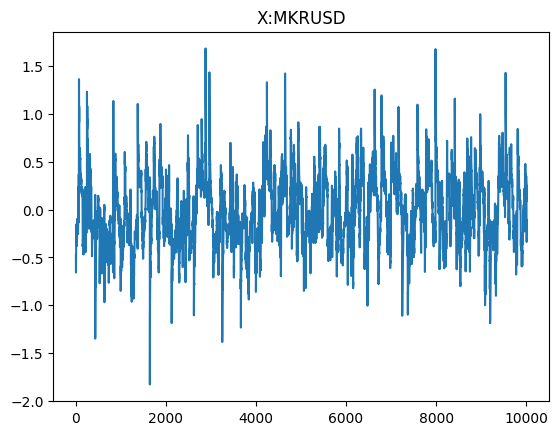

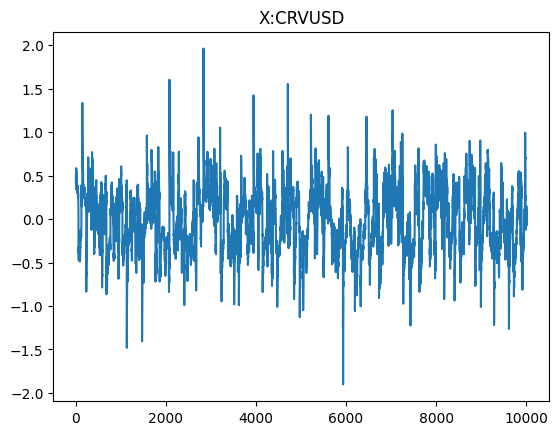

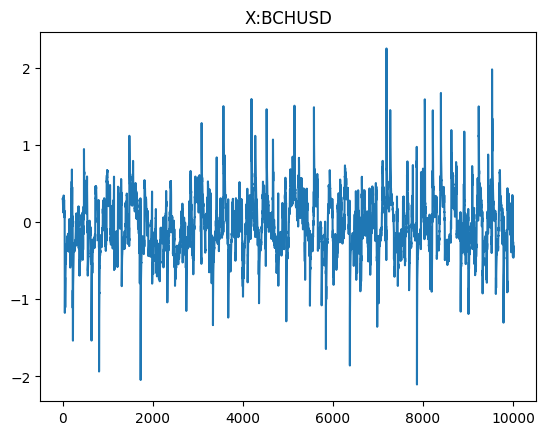

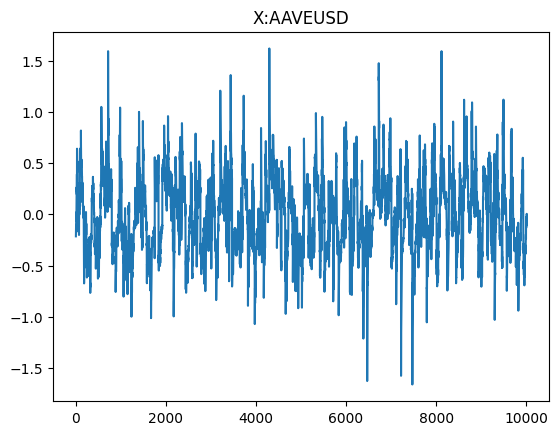

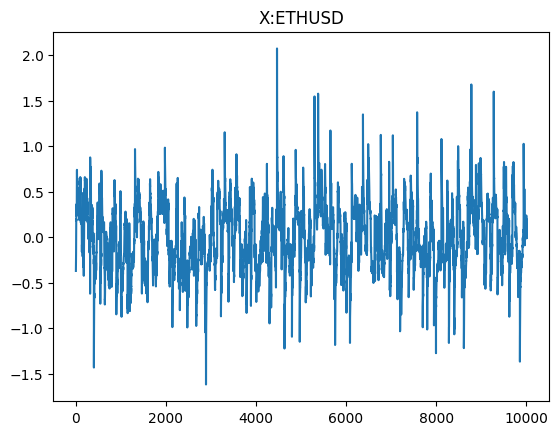

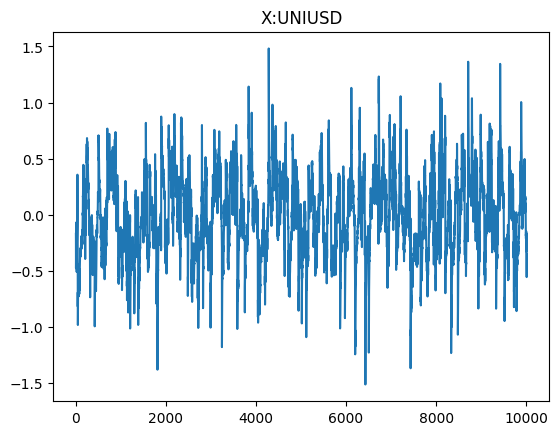

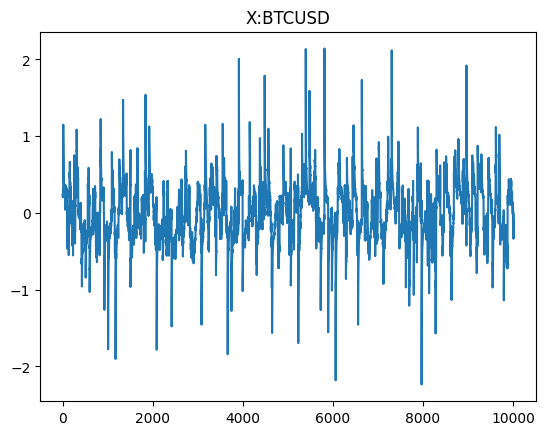

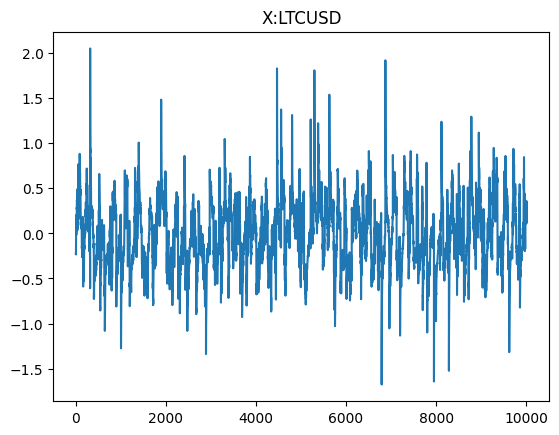

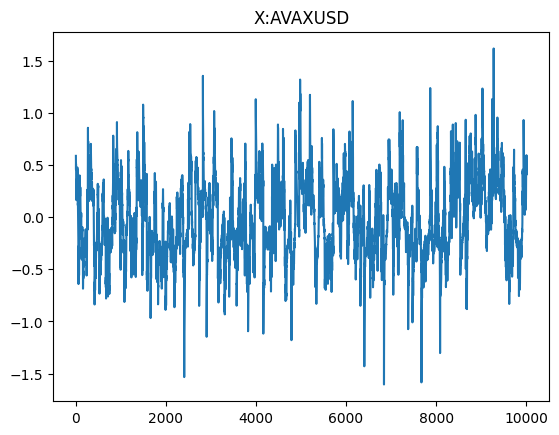

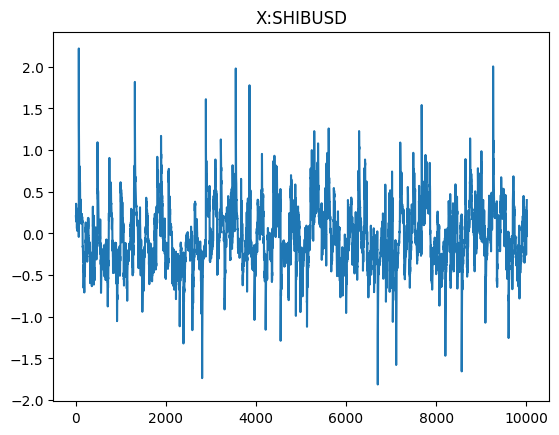

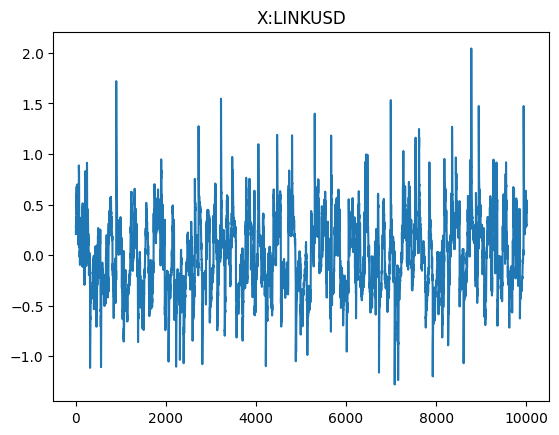

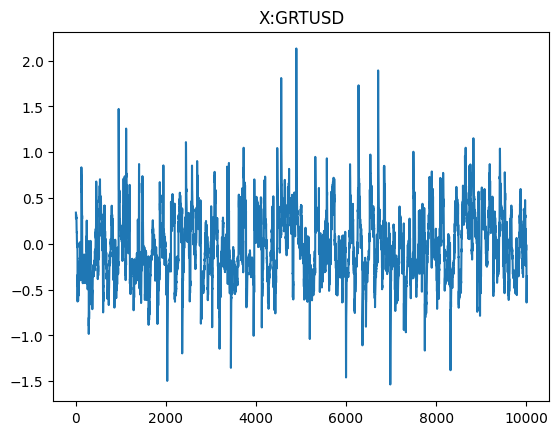

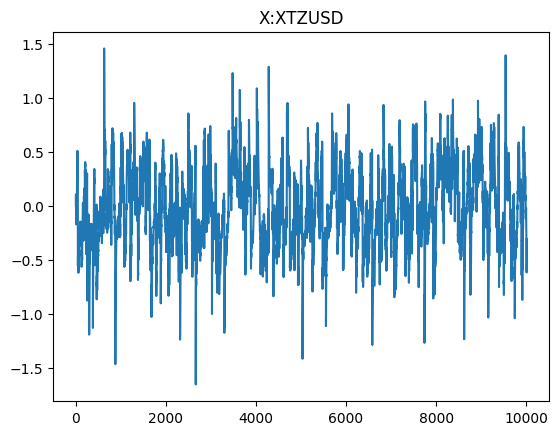

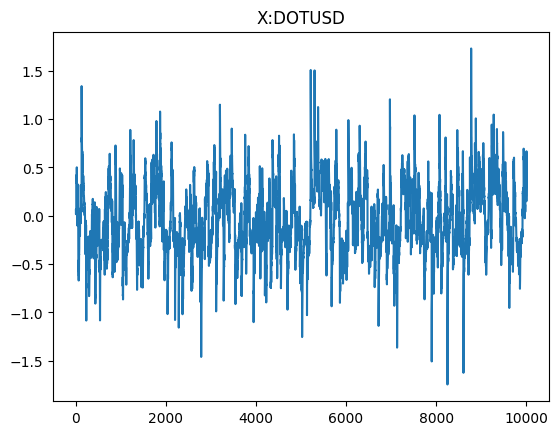

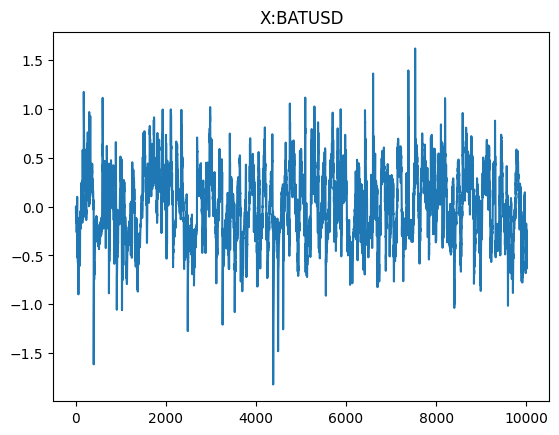

In [6]:
# plot price_data matplotlib
import matplotlib.pyplot as plt

for symbol in data.keys():
    plt.figure()
    plt.plot(data[symbol]['f_bbands_2'])
    plt.title(symbol)

# check features to be unique

In [7]:

# Assuming data_dict is your existing dictionary
# Reconstruct each ticker's DataFrame
reconstructed_dfs = []
for ticker, col_data in data.items():
    ticker_df = pd.DataFrame(col_data)
    ticker_df['ticker'] = ticker  # Add ticker as a column for later MultiIndex creation
    reconstructed_dfs.append(ticker_df)

# Concatenate all reconstructed DataFrames
concatenated_df = pd.concat(reconstructed_dfs)

# Set the index to be a MultiIndex of ticker and the original index
multiindex_df = concatenated_df.set_index(['ticker', concatenated_df.index])

# Optional: If the original index was a timestamp, you might need to sort by the MultiIndex
multiindex_df.sort_index(inplace=True)

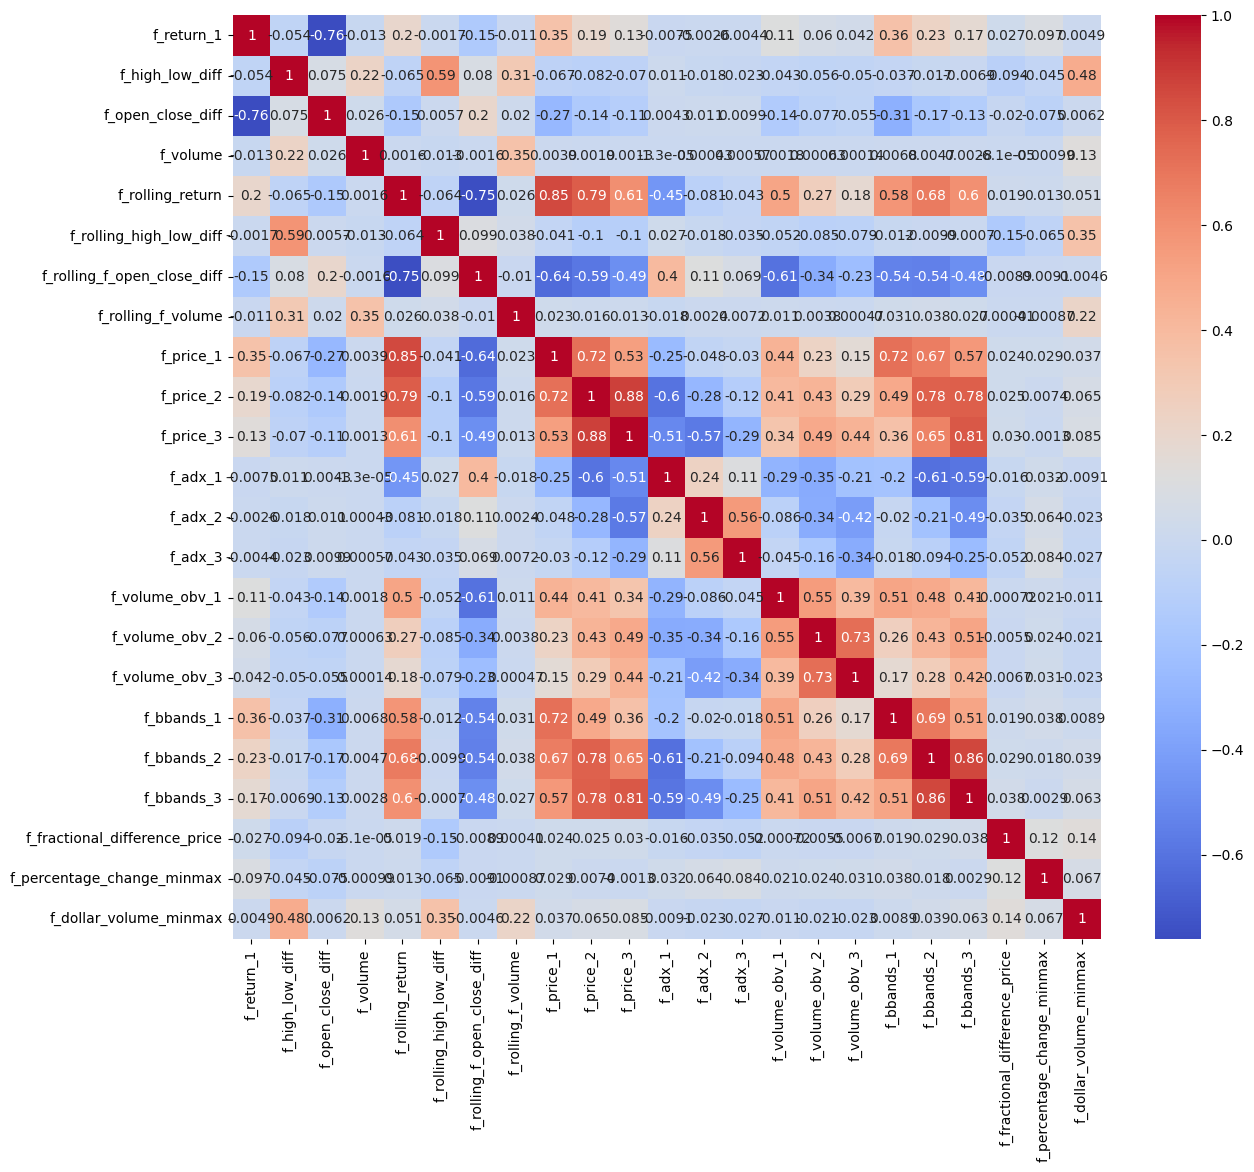

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter columns that start with 'f_'
f_columns = [col for col in multiindex_df.columns if col.startswith('f_')]

# Calculate the correlation matrix for only those columns
correlation_matrix = multiindex_df[f_columns].corr()

# Plot the heatmap
plt.figure(figsize=(14, 12))  # Set the size of the figure
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.show()


In [9]:
# Set a threshold for high correlation
threshold = 0.8

# Find and collect highly correlated pairs
to_drop = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            # Get the name of the feature to drop (you could also use other logic to choose which one to drop)
            colname = correlation_matrix.columns[i]
            to_drop.add(colname)

In [10]:
# what features need to be dropped
to_drop

{'f_bbands_2', 'f_price_2', 'f_price_3', 'f_rolling_return'}

In [ ]:
np.log(1.00001)

In [ ]:
def scale_action_vector(action_vector):
    # output is tanh, we want deadzone safespace between -0.7 and -1
    # Scale values from [-0.7, 1] to [0, 1]
    min_value = -0.7
    max_value = 1

    return np.clip((action_vector - min_value) / (max_value - min_value), 0,1)

def bin_action_values(action_vector):
    # Define the bin edges
    # max is never 1 to dissallow 100% utilization of the portfolio
    bins = np.arange(0, 1.0, 0.025)
    action_vector_reshaped = action_vector.reshape(-1, 1)
    abs_diff = np.abs(action_vector_reshaped - bins)
    closest_bin_indices = np.argmin(abs_diff, axis=1)
    binned_action_vector = bins[closest_bin_indices]

    return binned_action_vector

def normalize_action_vector(action_vector):
    # scale sum of action vector to 1
    action_vector_sum = np.sum(action_vector)
    action_vector = action_vector / action_vector_sum

    return action_vector

In [ ]:
# Example usage
#actions_vector = np.array([-1, -1, -1, -1, 0, 0.1, 1])  # Sample vector
actions_vector = np.array([-1, -0.8, -0.7, -0.5, 0, 0.5, 1])  # Sample vector
actions_vector = scale_action_vector(actions_vector)
scaled_binned_actions = normalize_action_vector(actions_vector)
bin_binned_actions = bin_action_values(scaled_binned_actions)
print(bin_binned_actions)

In [ ]:
actions_vector

In [ ]:
scaled_binned_actions

In [ ]:
bin_binned_actions

In [ ]:
    
class TradingBot:
    def __init__(self, decay_factor=0.9, frame_stack=10):
        self.decay_factor = decay_factor  # Decay factor for exponential sampling
        self.frame_stack = frame_stack  # Number of frames to stack
        self.observations = []  # Store observations with decay
        # Other initialization code...
        self.features = ['f_percentage_change_zscore', 'f_dollar_volume_zscore', 'f_sma',
            'f_fractional_difference_price', 'f_vmar', 'f_cumulative_return']

    def next_observation(self, index=None):
        
        feature_arrays = []
        
        # Dynamic extraction of features
        for feature_name in self.features:
            feature_array = np.array([data[symbol][feature_name][index]
                                      for symbol in data.keys()], dtype=np.float32)
            feature_arrays.append(feature_array)

        # Perform the division with safe check
        holdings_array = np.zeros( len(data.keys())  )

        # Ensure the result is in float32 format
        holdings_array = holdings_array.astype(np.float32)

        # Calculate unrealized P/L
        unrealized_pl_array = np.zeros( len(data.keys())  )

        # Ensure the result is in float32 format
        unrealized_pl_array = unrealized_pl_array.astype(np.float32)

        # Construct the observation array for the current step
        # Shape will be [num_features, num_symbols]
        current_observation = np.stack(
            [unrealized_pl_array, holdings_array] + feature_arrays, axis=0)

        # Transpose the observation to make it [num_symbols, num_features]
        current_observation = np.transpose(
            np.clip(current_observation, -3, 3), (1, 0))

        # Apply exponential decay to historical observations
        self.observations = [obs * self.decay_factor for obs in self.observations]

        # Add the current observation
        self.observations.append(current_observation)

        # Ensure the deque has a maximum length of FRAMESTACK
        self.observations = self.observations[-self.frame_stack:]

        # Stack the observations to create the final array
        # This will stack the last FRAMESTACK observations along a new dimension
        stacked_obs = np.stack(self.observations, axis=-1)


        return stacked_obs

In [ ]:
tb = TradingBot()

In [ ]:
# plot x
x = tb.next_observation(index=212)

In [ ]:
x.shape

In [ ]:
count = 212

In [ ]:
import matplotlib.pyplot as plt
# plot x
count+=1
x = tb.next_observation(index=count)
# Assuming 'x' is the output with shape (15, 8, 10)
# Choose a symbol to visualize, for example, symbol 0
symbol_index = 0

num_features = x.shape[1]
num_frames = x.shape[2]

# Create a figure with subplots for each feature
fig, axs = plt.subplots(num_features, 1, figsize=(10, 20))

# Iterate over each feature
for i in range(num_features):
    # Plot the feature across all frames for the chosen symbol
    axs[i].plot(range(num_frames), x[symbol_index, i, :], marker='o')
    axs[i].set_title(f'Feature {i+1} over Time for Symbol {symbol_index+1}')
    axs[i].set_xlabel('Frame')
    axs[i].set_ylabel('Feature Value')

plt.tight_layout()
plt.show()
